In [2]:
import numpy as np
import os 
import json
from sklearn.model_selection import train_test_split



ModuleNotFoundError: No module named 'sklearn'

In [6]:
annotation_train_dir = "../ann_train_val/ann_train_val/"
files = os.listdir(annotation_train_dir)

poses = {}

for pose in files:
    with open(os.path.join(annotation_train_dir,pose)) as f:
        data = json.load(f)
        poses.update({pose.replace('.json',''): data})

In [7]:
data = {

}

for pose in poses.keys():
    data.update({pose:[]})


for pose in poses.keys():
    for image in poses[pose].keys():
        landmarks = poses[pose][image]["landmarks"]
        if len(landmarks[0]) == 21:
            data[pose].append(np.array(landmarks[0]).squeeze().flatten())



In [8]:
for pose in data.keys():
    data.update({pose:np.stack(data[pose])})






In [9]:
def create_dataset(dataset):
    x = np.array([])
    y = np.array([])

    for index,pose in enumerate(data.keys()):
        _y = np.zeros((18))
        _y[index] = 1
        _y = np.tile(_y,(len(data[pose]),1))
        if len(x) == 0:
            x = data[pose]
            y = _y
        else:
            x = np.concatenate((x,data[pose]))
            y = np.concatenate((y,_y))
    return x,y


In [10]:
from tensorflow.keras.utils import Sequence

BATCH_SIZE = 64


class LandmarkSet(Sequence):
    def __init__(self,x,y,batch_size):
        self.x = x
        self.y = y
        self.batch_size = batch_size


    def __getitem__(self,idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
    
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))




x,y = create_dataset(data)
features_train, features_test_val, labels_train, labels_test_val = train_test_split(x, y,
                                                                            test_size = 0.2, shuffle = True)

features_val, features_test, labels_val, labels_test = train_test_split(features_test_val, 
                                                                        labels_test_val,test_size=0.5, shuffle = True)


train_gen = LandmarkSet(features_train, labels_train, BATCH_SIZE)
val_gen = LandmarkSet(features_val, labels_val, BATCH_SIZE)
test_gen = LandmarkSet(features_test, labels_test, BATCH_SIZE)

In [65]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=42))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(18,activation='softmax'))
    
    return model



In [66]:
model = create_model()

In [67]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

In [68]:
history = model.fit(train_gen, epochs = 200, batch_size = 256, shuffle = True, validation_data=val_gen)

Epoch 1/200
22/22 [==============================] - 1s 25ms/step - loss: 2.8923 - accuracy: 0.0584 - val_loss: 2.8892 - val_accuracy: 0.0296
Epoch 2/200
22/22 [==============================] - 0s 14ms/step - loss: 2.8777 - accuracy: 0.0777 - val_loss: 2.8859 - val_accuracy: 0.0473
Epoch 3/200
22/22 [==============================] - 0s 15ms/step - loss: 2.8699 - accuracy: 0.0843 - val_loss: 2.8818 - val_accuracy: 0.0651
Epoch 4/200
22/22 [==============================] - 0s 14ms/step - loss: 2.8629 - accuracy: 0.0799 - val_loss: 2.8769 - val_accuracy: 0.0592
Epoch 5/200
22/22 [==============================] - 0s 13ms/step - loss: 2.8523 - accuracy: 0.0917 - val_loss: 2.8676 - val_accuracy: 0.1006
Epoch 6/200
22/22 [==============================] - 0s 15ms/step - loss: 2.8412 - accuracy: 0.1109 - val_loss: 2.8664 - val_accuracy: 0.0592
Epoch 7/200
22/22 [==============================] - 0s 15ms/step - loss: 2.8287 - accuracy: 0.1176 - val_loss: 2.8571 - val_accuracy: 0.1006
Epoch 

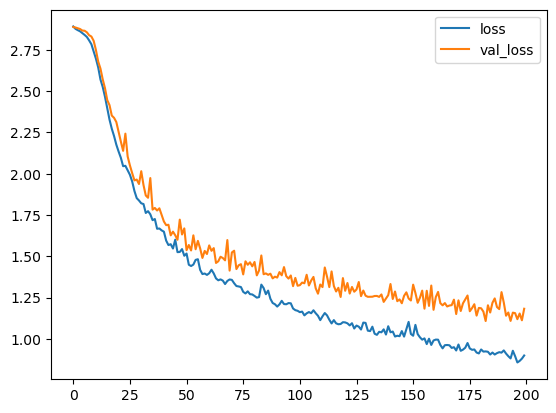

In [69]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])

plt.show()

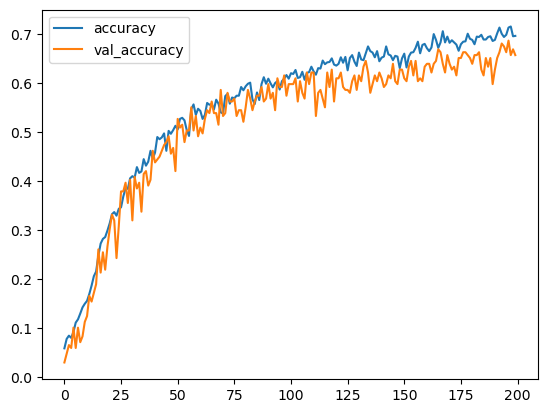

In [70]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy', 'val_accuracy'])

plt.show()

In [11]:
# landmark_set = LandmarkSet(data)
# length = len(landmark_set)
# train_data,valid_data,test_data= random_split(landmark_set,[int(x * length) for x in [0.8,0.1,0.1]])# 


In [118]:
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(valid_data,batch_size=64,shuffle=True)

In [186]:

GestureModel = nn.Sequential(
    nn.Linear(42,30),
    nn.ReLU(),
    nn.Linear(30,21),
    nn.ReLU(),
    nn.Linear(21,18),
    nn.ReLU()
)

In [190]:
EPOCHS = 100
lr = 1e-1
loss_func = nn.CrossEntropyLoss()
opt = SGD(GestureModel.parameters(),lr=lr)
def fit():
    for epoch in range(EPOCHS):
        epoch_train_loss = 0
        epoch_valid_loss = 0
        for batch in train_dataloader:
            xb,yb = batch
            preds = GestureModel(xb)
            loss = loss_func(preds,yb)
            with torch.no_grad():
                epoch_train_loss += loss
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        print(f"Epoch {epoch} train Loss: {epoch_train_loss/len(train_dataloader)}")

        for batch in valid_dataloader:
            with torch.no_grad():
                xb,yb = batch
                preds = GestureModel(xb)
                loss = loss_func(preds,yb)
                with torch.no_grad():
                    epoch_valid_loss += loss
        
        print(f"Epoch {epoch} valid Loss: {epoch_valid_loss/len(valid_dataloader)}")



fit()




Epoch 0 train Loss: 2.890371561050415
Epoch 0 valid Loss: 2.8903720378875732
Epoch 1 train Loss: 2.890371561050415
Epoch 1 valid Loss: 2.8903720378875732
Epoch 2 train Loss: 2.890371561050415
Epoch 2 valid Loss: 2.8903720378875732
Epoch 3 train Loss: 2.890371561050415
Epoch 3 valid Loss: 2.890371561050415
Epoch 4 train Loss: 2.890371561050415
Epoch 4 valid Loss: 2.8903720378875732
Epoch 5 train Loss: 2.890371561050415
Epoch 5 valid Loss: 2.8903720378875732
Epoch 6 train Loss: 2.890371561050415
Epoch 6 valid Loss: 2.8903720378875732
Epoch 7 train Loss: 2.890371561050415
Epoch 7 valid Loss: 2.8903720378875732
Epoch 8 train Loss: 2.890371561050415
Epoch 8 valid Loss: 2.8903720378875732
Epoch 9 train Loss: 2.890371561050415
Epoch 9 valid Loss: 2.890371561050415
Epoch 10 train Loss: 2.890371561050415
Epoch 10 valid Loss: 2.8903720378875732
Epoch 11 train Loss: 2.890371561050415
Epoch 11 valid Loss: 2.8903720378875732
Epoch 12 train Loss: 2.890371561050415
Epoch 12 valid Loss: 2.890371561050

In [156]:
import torch.nn as nn
 
ce = nn.CrossEntropyLoss()
 
logits = torch.tensor([[-1.90, -0.29, -2.30], [-0.29, -1.90, -2.30]])
target = torch.tensor([[0., 1., 0.], [1., 0., 0.]])
logits.shape
target.shape
# print("Cross entropy: %.3f" % ce(logits, target))

torch.Size([2, 3])